# Data Aggregation

Original notebook - also can be found as python script. Code here is a bit scrappy as it was experimental.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

#data read
cust = pd.read_csv('banking_churn_data/customers_clean.csv')
trans = pd.read_csv('banking_churn_data/transactions_clean.csv')

### Cleaning

### Aggregation

In [248]:
#aggregate by month
#date column is end of month of transaction date
# we can sum by month
trans['is_deposit'] = (trans['deposit']>0).astype(int)
trans['is_withdraw'] = (trans['withdrawal']<0).astype(int)
#trans.drop('account_id', axis=1,inplace=True)
trans_agg = trans.groupby(['date', 'customer_id'], as_index=False).sum()
trans_agg = trans_agg.merge(cust, how='outer', on='customer_id')
trans_agg['creation_month'] = (trans_agg['date']==trans_agg['creation_date']).astype(int)
trans_agg['month_start'] = trans_agg['start_balance'] * trans_agg['creation_month']
trans_agg['month_start'] = trans_agg['month_start'].apply(lambda x: np.nan if x==0 else x)
trans_agg['month_end'] = trans_agg['month_start'] +trans_agg['amount']
trans_agg.head(5)

date  customer_id   amount  deposit  withdrawal  is_deposit  \
0  2007-01-31           91 -2260.92  3034.26    -5295.18           1   
1  2007-02-28           91     0.00     0.00        0.00           0   
2  2007-03-31           91     0.00     0.00        0.00           0   
3  2007-01-31           92     0.00     0.00        0.00           0   
4  2007-02-28           92  1164.90  1164.90        0.00           1   

   is_withdraw         dob       state  start_balance creation_date  \
0            1  1993-07-01  California       10180.56    2007-01-31   
1            0  1993-07-01  California       10180.56    2007-01-31   
2            0  1993-07-01  California       10180.56    2007-01-31   
3            0  1985-12-05    New York        4757.68    2007-01-31   
4            0  1985-12-05    New York        4757.68    2007-01-31   

   creation_month  month_start  month_end  
0               1     10180.56    7919.64  
1               0          NaN        NaN  
2               0          NaN        NaN  
3               1      4757.68    4757.68  
4               0          NaN        NaN

In [249]:
print(trans_agg.shape)
#trans_agg[trans_agg['dob'].isnull()]
trans_agg.isnull().sum()

(2128796, 14)


date                    0
customer_id             0
amount                  0
deposit                 0
withdrawal              0
is_deposit              0
is_withdraw             0
dob                     0
state                   0
start_balance           0
creation_date           0
creation_month          0
month_start       2012796
month_end         2012796
dtype: int64

In [250]:
while trans_agg['month_end'].isnull().sum()>0:
    trans_agg['month_start']=trans_agg['month_start'].fillna(trans_agg.month_end.shift(1))
    trans_agg['month_end'] = trans_agg['month_start'] + trans_agg['amount']
trans_agg.head()

date  customer_id   amount  deposit  withdrawal  is_deposit  \
0  2007-01-31           91 -2260.92  3034.26    -5295.18           1   
1  2007-02-28           91     0.00     0.00        0.00           0   
2  2007-03-31           91     0.00     0.00        0.00           0   
3  2007-01-31           92     0.00     0.00        0.00           0   
4  2007-02-28           92  1164.90  1164.90        0.00           1   

   is_withdraw         dob       state  start_balance creation_date  \
0            1  1993-07-01  California       10180.56    2007-01-31   
1            0  1993-07-01  California       10180.56    2007-01-31   
2            0  1993-07-01  California       10180.56    2007-01-31   
3            0  1985-12-05    New York        4757.68    2007-01-31   
4            0  1985-12-05    New York        4757.68    2007-01-31   

   creation_month  month_start  month_end  
0               1     10180.56    7919.64  
1               0      7919.64    7919.64  
2               0      7919.64    7919.64  
3               1      4757.68    4757.68  
4               0      4757.68    5922.58

In [251]:
#get churns - defined as them dropping off book
trans_agg['churn'] = (trans_agg['customer_id'].shift(-1)!=trans_agg['customer_id']).astype(int)
#trans_agg['churn'] = trans_agg['churn'].apply(lambda x: )

In [252]:
churn_rate = (trans_agg.groupby('date')['churn'].sum()/trans_agg.groupby('date')['churn'].count())*100
churn_rate[churn_rate<100].describe()

count    160.000000
mean       4.743723
std        1.285926
min        1.210242
25%        3.521695
50%        4.977716
75%        6.051279
max        6.705817
Name: churn, dtype: float64

In [253]:
#milan features
trans_agg['date_month'] = pd.to_datetime(trans_agg['date']).dt.to_period('m')
trans_agg['dob'] = pd.to_datetime(trans_agg['dob']).dt.to_period('m')
trans_agg['creation_date_month'] = pd.to_datetime(trans_agg['creation_date']).dt.to_period('m')
trans_agg['months_w_bank'] = (trans_agg['date_month'].astype(int) - trans_agg['creation_date_month'].astype(int))#
trans_agg['age'] = round((trans_agg['date_month'].astype(int) - trans_agg['dob'].astype(int))/12, 2)

new_agg = trans_agg.groupby('customer_id').amount.rolling(3).sum().reset_index().drop(['customer_id', 'level_1'], axis=1)
new_agg = new_agg.rename(columns={'amount':'amount_agg'})
trans_agg = pd.merge(trans_agg, new_agg, left_index=True, right_index=True)


# Rolling for is_deposit over 3 months
new_agg = trans_agg.groupby('customer_id').is_deposit.rolling(3).sum().reset_index().drop(['customer_id', 'level_1'], axis=1)
new_agg = new_agg.rename(columns={'is_deposit':'is_depo_roll'})
trans_agg = pd.merge(trans_agg, new_agg, left_index=True, right_index=True)

# Rolling for is_withdraw over 3 months
new_agg = trans_agg.groupby('customer_id').is_withdraw.rolling(3).sum().reset_index().drop(['customer_id', 'level_1'], axis=1)
new_agg = new_agg.rename(columns={'is_withdraw':'is_wdraw_roll'})
trans_agg = pd.merge(trans_agg, new_agg, left_index=True, right_index=True)

In [254]:
trans_agg.head()

date  customer_id   amount  deposit  withdrawal  is_deposit  \
0  2007-01-31           91 -2260.92  3034.26    -5295.18           1   
1  2007-02-28           91     0.00     0.00        0.00           0   
2  2007-03-31           91     0.00     0.00        0.00           0   
3  2007-01-31           92     0.00     0.00        0.00           0   
4  2007-02-28           92  1164.90  1164.90        0.00           1   

   is_withdraw      dob       state  start_balance  ... month_start  \
0            1  1993-07  California       10180.56  ...    10180.56   
1            0  1993-07  California       10180.56  ...     7919.64   
2            0  1993-07  California       10180.56  ...     7919.64   
3            0  1985-12    New York        4757.68  ...     4757.68   
4            0  1985-12    New York        4757.68  ...     4757.68   

   month_end  churn  date_month  creation_date_month months_w_bank    age  \
0    7919.64      0     2007-01              2007-01             0  13.50   
1    7919.64      0     2007-02              2007-01             1  13.58   
2    7919.64      1     2007-03              2007-01             2  13.67   
3    4757.68      0     2007-01              2007-01             0  21.08   
4    5922.58      0     2007-02              2007-01             1  21.17   

   amount_agg  is_depo_roll  is_wdraw_roll  
0         NaN           NaN            NaN  
1         NaN           NaN            NaN  
2    -2260.92           1.0            1.0  
3         NaN           NaN            NaN  
4         NaN           NaN            NaN  

[5 rows x 22 columns]

In [255]:
# date - ennd of month date
# amount - sum of deposit and withdrawl for that month
# is_deposit - number of deposits in month
# is_withdraw - number of withdrawls in the month
# mopnth_start - balance at start of month
# month_end - balance at end of month 

In [256]:
# Putting Census regions into DataFrame
state_data = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')
state_data = state_data.rename(columns={"State": "state"})
print(state_data.Division.unique())

['Pacific' 'East South Central' 'West South Central' 'Mountain'
 'New England' 'South Atlantic' 'West North Central' 'East North Central'
 'Middle Atlantic']


In [257]:
trans_agg = pd.merge(trans_agg,state_data, on='state', how='left')

In [258]:
trans_agg.head()

date  customer_id   amount  deposit  withdrawal  is_deposit  \
0  2007-01-31           91 -2260.92  3034.26    -5295.18           1   
1  2007-02-28           91     0.00     0.00        0.00           0   
2  2007-03-31           91     0.00     0.00        0.00           0   
3  2007-01-31           92     0.00     0.00        0.00           0   
4  2007-02-28           92  1164.90  1164.90        0.00           1   

   is_withdraw      dob       state  start_balance  ... date_month  \
0            1  1993-07  California       10180.56  ...    2007-01   
1            0  1993-07  California       10180.56  ...    2007-02   
2            0  1993-07  California       10180.56  ...    2007-03   
3            0  1985-12    New York        4757.68  ...    2007-01   
4            0  1985-12    New York        4757.68  ...    2007-02   

   creation_date_month  months_w_bank    age  amount_agg is_depo_roll  \
0              2007-01              0  13.50         NaN          NaN   
1              2007-01              1  13.58         NaN          NaN   
2              2007-01              2  13.67    -2260.92          1.0   
3              2007-01              0  21.08         NaN          NaN   
4              2007-01              1  21.17         NaN          NaN   

  is_wdraw_roll  State Code     Region         Division  
0           NaN          CA       West          Pacific  
1           NaN          CA       West          Pacific  
2           1.0          CA       West          Pacific  
3           NaN          NY  Northeast  Middle Atlantic  
4           NaN          NY  Northeast  Middle Atlantic  

[5 rows x 25 columns]

In [259]:
trans_agg['date']=pd.to_datetime(trans_agg['date'])

In [260]:
def create_df(file_path, region):
    unemp = pd.read_excel(file_path)
    df = pd.DataFrame(unemp)
    df = df.iloc[10:]
    df = df.rename(columns={"Unnamed: 1": "unemployment_rate", "FRED Graph Observations": "date"})
    df['date']=df['date']-timedelta(days=1)
    df['Division']= f'{region}'
    return df

In [261]:
#Getting unemployment rate data for census regions
ENC_unemp_df = create_df('churn_project/banking_churn_data/external/East North Central.xls', 'East North Central')
ESC_unemp_df = create_df('churn_project/banking_churn_data/external/East South Central.xls', 'East South Central')
MAT_unemp_df = create_df('churn_project/banking_churn_data/external/Middle Atlantic.xls', 'Middle Atlantic')
MOU_unemp_df = create_df('churn_project/banking_churn_data/external/Mountain.xls', 'Mountain')
NEW_unemp_df = create_df('churn_project/banking_churn_data/external/New England.xls', 'New England')
PAC_unemp_df = create_df('churn_project/banking_churn_data/external/Pacific.xls', 'Pacific')
SAT_unemp_df = create_df('churn_project/banking_churn_data/external/South Atlantic.xls', 'South Atlantic')
WNC_unemp_df = create_df('churn_project/banking_churn_data/external/West North Central.xls', 'West North Central')
WSC_unemp_df = create_df('churn_project/banking_churn_data/external/West South Central.xls', 'West South Central')

unemp_df = pd.concat([ENC_unemp_df,ESC_unemp_df,MAT_unemp_df, MOU_unemp_df,NEW_unemp_df,PAC_unemp_df,SAT_unemp_df,WNC_unemp_df,WSC_unemp_df])

#GDP data
GDP_df = pd.read_excel('churn_project/banking_churn_data/external/GDP_quarterly.xls')
GDP_df = GDP_df.iloc[10:]
GDP_df = GDP_df.rename(columns={"Unnamed: 1": "GDP", "FRED Graph Observations": "date"})
GDP_df = GDP_df.rename(columns={"observed_date":"date"})
GDP_df['date']=GDP_df['date']-timedelta(days=1)

#merge GDP and uneployment rate data
GDP_unemp_df = pd.merge(unemp_df, GDP_df, on='date', how='left')
GDP_unemp_df = GDP_unemp_df.ffill()
GDP_unemp_df

date  unemployment_rate            Division        GDP
0    2006-01-31                5.4  East North Central        NaN
1    2006-02-28                5.4  East North Central        NaN
2    2006-03-31                5.3  East North Central  13749.806
3    2006-04-30                5.3  East North Central  13749.806
4    2006-05-31                5.3  East North Central  13749.806
...         ...                ...                 ...        ...
1552 2020-01-31                3.8  West South Central  21561.139
1553 2020-02-29                4.7  West South Central  21561.139
1554 2020-03-31               12.7  West South Central  19520.114
1555 2020-04-30               11.3  West South Central  19520.114
1556 2020-05-31                9.7  West South Central  19520.114

[1557 rows x 4 columns]

<AxesSubplot:xlabel='date'>

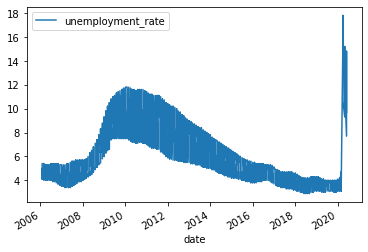

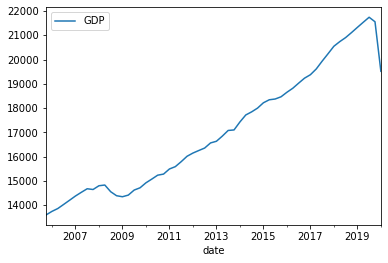

In [262]:
unemp_df.plot(x='date')
GDP_df.plot(x='date')

In [263]:
trans_agg = trans_agg.merge(GDP_unemp_df, on=['date', 'Division'], how='left')

In [264]:
trans_agg.head()

date  customer_id   amount  deposit  withdrawal  is_deposit  \
0 2007-01-31           91 -2260.92  3034.26    -5295.18           1   
1 2007-02-28           91     0.00     0.00        0.00           0   
2 2007-03-31           91     0.00     0.00        0.00           0   
3 2007-01-31           92     0.00     0.00        0.00           0   
4 2007-02-28           92  1164.90  1164.90        0.00           1   

   is_withdraw      dob       state  start_balance  ... months_w_bank    age  \
0            1  1993-07  California       10180.56  ...             0  13.50   
1            0  1993-07  California       10180.56  ...             1  13.58   
2            0  1993-07  California       10180.56  ...             2  13.67   
3            0  1985-12    New York        4757.68  ...             0  21.08   
4            0  1985-12    New York        4757.68  ...             1  21.17   

   amount_agg  is_depo_roll  is_wdraw_roll State Code     Region  \
0         NaN           NaN            NaN         CA       West   
1         NaN           NaN            NaN         CA       West   
2    -2260.92           1.0            1.0         CA       West   
3         NaN           NaN            NaN         NY  Northeast   
4         NaN           NaN            NaN         NY  Northeast   

          Division  unemployment_rate        GDP  
0          Pacific                4.9  14208.569  
1          Pacific                4.9  14208.569  
2          Pacific                4.9  14382.363  
3  Middle Atlantic                4.2  14208.569  
4  Middle Atlantic                4.2  14208.569  

[5 rows x 27 columns]

## Real Interest Rates
---

In [265]:
inflation_file = r'churn_project/banking_churn_data/external/Inflation_rate_monthly_US.csv'

df_inflation = pd.read_csv(inflation_file)

df_inflation.rename(columns={'DATE':'date', 'CPALTT01USM657N':'inflation_rate'}, inplace=True)
df_inflation['date'] = pd.to_datetime(df_inflation['date'], format='%d/%m/%Y')
df_inflation['date'] = df_inflation['date']-timedelta(days=1)
df_inflation.drop([0], axis=0, inplace=True)
df_inflation.drop(df_inflation.index[0], inplace=True)
df_inflation.drop(df_inflation.index[-1], inplace=True)
df_inflation.set_index(df_inflation['date'], inplace=True)
df_inflation['date'] = df_inflation['date'].dt.to_period('M')
df_inflation.rename(columns={'date':'date_month'}, inplace=True)

In [266]:
interest_rate_file = r'churn_project/banking_churn_data/external/Interest_rates_monthly_US.csv'

df_interest_rate = pd.read_csv(interest_rate_file)

df_interest_rate.rename(columns={'DATE':'date', 'DFF':'interest_rate'}, inplace=True)
df_interest_rate['date'] = pd.to_datetime(df_interest_rate['date'], format='%d/%m/%Y')
df_interest_rate['date'] = df_interest_rate['date']-timedelta(days=1)
df_interest_rate.drop(df_interest_rate.index[0], inplace=True)
df_interest_rate.drop(df_interest_rate.index[-1], inplace=True)
df_interest_rate.set_index(df_interest_rate['date'], inplace=True)
df_interest_rate['date'] = df_interest_rate['date'].dt.to_period('M')
df_interest_rate.rename(columns={'date':'date_month'}, inplace=True)

df_interest_rate

date_month  interest_rate
date                                
2007-01-31    2007-01       5.258929
2007-02-28    2007-02       5.256774
2007-03-31    2007-03       5.249667
2007-04-30    2007-04       5.253548
2007-05-31    2007-05       5.254000
...               ...            ...
2020-01-31    2020-01       1.583103
2020-02-29    2020-02       0.652258
2020-03-31    2020-03       0.049000
2020-04-30    2020-04       0.050000
2020-05-31    2020-05       0.077667

[161 rows x 2 columns]

In [267]:
df_external = df_interest_rate.copy()
df_external['inflation_rate'] = df_inflation['inflation_rate']
df_external['real_interest_rate'] = df_external['interest_rate'] - df_external['inflation_rate']
df_external.drop(columns=['interest_rate','inflation_rate'], axis=1, inplace=True)
df_external

date_month  real_interest_rate
date                                     
2007-01-31    2007-01            4.723892
2007-02-28    2007-02            4.346205
2007-03-31    2007-03            4.600050
2007-04-30    2007-04            4.642477
2007-05-31    2007-05            5.060202
...               ...                 ...
2020-01-31    2020-01            1.309042
2020-02-29    2020-02            0.869903
2020-03-31    2020-03            0.717694
2020-04-30    2020-04            0.048050
2020-05-31    2020-05           -0.469538

[161 rows x 2 columns]

In [268]:
trans_agg = trans_agg.merge(df_external, how='left', left_on=['date'], right_on=['date'])

In [269]:
#add us_sent
sent = pd.read_csv('churn_project/banking_churn_data/external/1UMCSENT.csv', index_col=0)
sent['DATE']= pd.to_datetime(sent['DATE'])
#sent['DATE'] = sent['DATE'].dt.date
sent = sent[sent['DATE']>'2007-01-01']
sent['DATE'] = sent['DATE']-timedelta(days=1)
#sent['DATE']=sent['DATE'].dt.date
#sent['DATE']= sent['DATE'].apply(str)
trans_agg = trans_agg.merge(sent, how='left', left_on=['date'], right_on=['DATE'])

# Change in interest rate and sentiment

In [270]:
#train = train.merge(train.groupby('date')['real_interest_rate'].mean().diff().fillna(0), how='left', on='date')
#train = train.merge(train.groupby('date')['UMCSENT'].mean().diff().pct_change().fillna(0), how='left', on='date')

delta_interest = pd.DataFrame(trans_agg.groupby('date')['real_interest_rate'].mean().diff().fillna(0))
delta_interest.columns = ['delta_interest']
delta_interest
trans_agg['UMCSENT'] = trans_agg['UMCSENT'].apply(float)
delta_sentiment = pd.DataFrame(trans_agg.groupby('date')['UMCSENT'].mean().diff().pct_change().fillna(0))
delta_sentiment.columns = ['delta_sentiment']
delta_sentiment
trans_agg = trans_agg.merge(delta_interest, on='date', how='left')
trans_agg = trans_agg.merge(delta_sentiment, on='date', how='left')

In [271]:
trans_agg.head()

date  customer_id   amount  deposit  withdrawal  is_deposit  \
0 2007-01-31           91 -2260.92  3034.26    -5295.18           1   
1 2007-02-28           91     0.00     0.00        0.00           0   
2 2007-03-31           91     0.00     0.00        0.00           0   
3 2007-01-31           92     0.00     0.00        0.00           0   
4 2007-02-28           92  1164.90  1164.90        0.00           1   

   is_withdraw      dob       state  start_balance  ...     Region  \
0            1  1993-07  California       10180.56  ...       West   
1            0  1993-07  California       10180.56  ...       West   
2            0  1993-07  California       10180.56  ...       West   
3            0  1985-12    New York        4757.68  ...  Northeast   
4            0  1985-12    New York        4757.68  ...  Northeast   

          Division  unemployment_rate        GDP  date_month_y  \
0          Pacific                4.9  14208.569       2007-01   
1          Pacific                4.9  14208.569       2007-02   
2          Pacific                4.9  14382.363       2007-03   
3  Middle Atlantic                4.2  14208.569       2007-01   
4  Middle Atlantic                4.2  14208.569       2007-02   

  real_interest_rate       DATE  UMCSENT  delta_interest  delta_sentiment  
0           4.723892 2007-01-31     91.3        0.000000         0.000000  
1           4.346205 2007-02-28     88.4       -0.377687         0.000000  
2           4.600050 2007-03-31     87.1        0.253846        -0.551724  
3           4.723892 2007-01-31     91.3        0.000000         0.000000  
4           4.346205 2007-02-28     88.4       -0.377687         0.000000  

[5 rows x 33 columns]

# Split into train and test

In [273]:
test =  trans_agg[trans_agg['date']=='2020-05-31'].reset_index()
train = trans_agg[trans_agg['date']!='2020-05-31'].reset_index()
print(test.shape)
print(train.shape)

(17245, 34)
(2111551, 34)


In [274]:
mean_amount = train['amount_agg'].mean()
mode_depo_roll = train['is_depo_roll'].mode()[0]
mode_wdraw_roll = train['is_wdraw_roll'].mode()[0]
print(mean_amount)
print(mode_depo_roll)
print(mode_wdraw_roll)

train['amount_agg'] = train['amount_agg'].fillna(mean_amount)
train['is_depo_roll'] = train['is_depo_roll'].fillna(mode_depo_roll)
train['is_wdraw_roll'] = train['is_wdraw_roll'].fillna(mode_wdraw_roll)
test['amount_agg'] = test['amount_agg'].fillna(mean_amount)
test['is_depo_roll'] = test['is_depo_roll'].fillna(mode_depo_roll)
test['is_wdraw_roll'] = test['is_wdraw_roll'].fillna(mode_wdraw_roll)

251.7095412365154
3.0
1.0


In [275]:
train.drop(['index','dob','state','creation_date','creation_month', 'date_month_x','creation_date_month','date_month_y','State Code','Region','DATE'], axis=1, inplace=True)
test.drop(['index','dob','state','creation_date','creation_month', 'date_month_x','creation_date_month','date_month_y','State Code','Region','DATE'], axis=1, inplace=True)

In [276]:
train.columns

Index(['date', 'customer_id', 'amount', 'deposit', 'withdrawal', 'is_deposit',
       'is_withdraw', 'start_balance', 'month_start', 'month_end', 'churn',
       'months_w_bank', 'age', 'amount_agg', 'is_depo_roll', 'is_wdraw_roll',
       'Division', 'unemployment_rate', 'GDP', 'real_interest_rate', 'UMCSENT',
       'delta_interest', 'delta_sentiment'],
      dtype='object')

In [277]:
new_names = ['date','customer_id','month_bal_change','month_deposit', 'month_withdrawal',
 'num_deposit','num_withdrawal','opening_balance','month_start_bal', 'month_end_bal','churn','account_age',
'customer_age','3month_bal_change','3month_num_deposit','3month_num_withdraw','Region','Region_unemployment',
'GDP', 'real_interest_rate','consumer_sentiment', 'interest_change','sentiment_change']
print(len(new_names))
print(len(train.columns))
train.columns = new_names
test.columns = new_names

23
23


In [278]:
test.drop('churn',axis=1, inplace=True)
print(test.shape)
print(train.shape)

(17245, 22)
(2111551, 23)


In [279]:
train.head()

date  customer_id  month_bal_change  month_deposit  month_withdrawal  \
0 2007-01-31           91          -2260.92        3034.26          -5295.18   
1 2007-02-28           91              0.00           0.00              0.00   
2 2007-03-31           91              0.00           0.00              0.00   
3 2007-01-31           92              0.00           0.00              0.00   
4 2007-02-28           92           1164.90        1164.90              0.00   

   num_deposit  num_withdrawal  opening_balance  month_start_bal  \
0            1               1         10180.56         10180.56   
1            0               0         10180.56          7919.64   
2            0               0         10180.56          7919.64   
3            0               0          4757.68          4757.68   
4            1               0          4757.68          4757.68   

   month_end_bal  ...  3month_bal_change  3month_num_deposit  \
0        7919.64  ...         251.709541                 3.0   
1        7919.64  ...         251.709541                 3.0   
2        7919.64  ...       -2260.920000                 1.0   
3        4757.68  ...         251.709541                 3.0   
4        5922.58  ...         251.709541                 3.0   

   3month_num_withdraw           Region  Region_unemployment        GDP  \
0                  1.0          Pacific                  4.9  14208.569   
1                  1.0          Pacific                  4.9  14208.569   
2                  1.0          Pacific                  4.9  14382.363   
3                  1.0  Middle Atlantic                  4.2  14208.569   
4                  1.0  Middle Atlantic                  4.2  14208.569   

  real_interest_rate  consumer_sentiment  interest_change  sentiment_change  
0           4.723892                91.3         0.000000          0.000000  
1           4.346205                88.4        -0.377687          0.000000  
2           4.600050                87.1         0.253846         -0.551724  
3           4.723892                91.3         0.000000          0.000000  
4           4.346205                88.4        -0.377687          0.000000  

[5 rows x 23 columns]

In [280]:
test.head()

date  customer_id  month_bal_change  month_deposit  month_withdrawal  \
0 2020-05-31          607           2140.17        2663.34           -523.17   
1 2020-05-31         1502            508.27         508.27              0.00   
2 2020-05-31         1682           1671.24        2248.52           -577.28   
3 2020-05-31         4369           2272.39        2272.39              0.00   
4 2020-05-31         5625           2285.85        2285.85              0.00   

   num_deposit  num_withdrawal  opening_balance  month_start_bal  \
0            1               4          8903.92         43530.92   
1            1               0          1851.12         11431.04   
2            1               2          7357.40         35078.05   
3            1               0          6425.40         50856.18   
4            1               0          7929.40         56024.89   

   month_end_bal  ...  3month_bal_change  3month_num_deposit  \
0       45671.09  ...            4385.90                 3.0   
1       11939.31  ...            1416.17                 3.0   
2       36749.29  ...            1947.34                 2.0   
3       53128.57  ...            5971.73                 3.0   
4       58310.74  ...            6788.40                 3.0   

   3month_num_withdraw              Region  Region_unemployment        GDP  \
0                  5.0  West South Central                  9.7  19520.114   
1                  4.0         New England                 12.2  19520.114   
2                  7.0  West South Central                  9.7  19520.114   
3                  0.0  West North Central                  7.7  19520.114   
4                  0.0  West South Central                  9.7  19520.114   

   real_interest_rate  consumer_sentiment  interest_change  sentiment_change  
0           -0.469538                78.1        -0.517588              10.6  
1           -0.469538                78.1        -0.517588              10.6  
2           -0.469538                78.1        -0.517588              10.6  
3           -0.469538                78.1        -0.517588              10.6  
4           -0.469538                78.1        -0.517588              10.6  

[5 rows x 22 columns]

In [281]:
train.to_csv('banking_churn_data/train_final.csv', index=False)
test.to_csv('banking_churn_data/test_final.csv', index=False)